# TP DEBANDI

## Análisis de los datos

Este notebook es la continuación de la notebook de carga de datos que pre-proceso los datos de casos de Covid entre enero 2020 y mayo 2021, sumándole la información sobre origen de nacimiento (1-creacion-dataset-parquet)

Para optimizar los tiempos de procesamiento y dado el volumen da datos se realizó el trabajo sobre una muestra del 10% (ver la notebook de carga)

Son 474.572 casos confirmados que incluyen las siguientes variables:

id_evento_caso: integer (nullable = true)
sexo: string (nullable = true)
edad: integer (nullable = true)
fecha_inicio_sintomas: date (nullable = true)
fecha_apertura: date (nullable = true)
sepi_apertura: integer (nullable = true)
origen_financiamiento: string (nullable = true)
residencia_provincia_id: string (nullable = true)
residencia_departamento_id: integer (nullable = true)
fecha_internacion: date (nullable = true)
cuidado_intensivo: string (nullable = true)
fallecido: string (nullable = true)
pais_nacimiento: string (nullable = true)

El objetivo es realizar un análisis exploratorio de los datos inicial y luego aplicar alguna técnica de aprendizaje supervisado.


In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("pyspark-intro")
    .config("spark.driver.memory", "512m")
    .config("spark.driver.cores", "1")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.cores", "1")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)

Se leen los datos desde el archivo parquet creado en la notebook previa.

In [3]:
#dfTemp2.write.parquet("/dataset/parquet-confirmados-muestra/covid-muestra.parquet") 
dfcovid=spark.read.parquet("/dataset/parquetv3/covidmigrantes.parquet") 



In [4]:
dfcovid.show(5)

+--------------+----+----+---------------------+-------------------+-------------------+-------------+---------------------+-----------------------+--------------------------+-------------------+-----------------+---------+---------------+
|id_evento_caso|sexo|edad|fecha_inicio_sintomas|     fecha_apertura|  fecha_diagnostico|sepi_apertura|origen_financiamiento|residencia_provincia_id|residencia_departamento_id|  fecha_internacion|cuidado_intensivo|fallecido|pais_nacimiento|
+--------------+----+----+---------------------+-------------------+-------------------+-------------+---------------------+-----------------------+--------------------------+-------------------+-----------------+---------+---------------+
|        740861|   F|  75|  2020-03-02 00:00:00|2020-03-07 00:00:00|2020-03-09 00:00:00|           10|              Público|                     22|                       140|               null|               NO|       NO|      Argentina|
|        744751|   M|  67|  2020-03-08 0

In [5]:
dfcovid.count()

474572

Se verifican que hay 474.572 casos

In [8]:
dfmigrantes.count()

11437754

In [17]:
dfmigrantes.printSchema()

root
 |-- id_caso: integer (nullable = true)
 |-- pais_nacimiento: string (nullable = true)



In [18]:
dfmigrantes.show(5)

+-------+---------------+
|id_caso|pais_nacimiento|
+-------+---------------+
| 718058|      Argentina|
| 718055|      Argentina|
| 718029|      Argentina|
| 717926|      Argentina|
| 717629|          China|
+-------+---------------+
only showing top 5 rows



In [19]:
dfcovid.show(5)

+--------------+----+----+---------------+----------------------+---------------------------+------------------------------+----------------------+---------------------+--------------+-------------+-----------------+-----------------+-------------------+---------+-------------------+--------------------------------+------------------+---------------------+-------------+---------------------+-----------------------+-----------------+--------------------------+--------------------+
|id_evento_caso|sexo|edad|edad_años_meses|residencia_pais_nombre|residencia_provincia_nombre|residencia_departamento_nombre|carga_provincia_nombre|fecha_inicio_sintomas|fecha_apertura|sepi_apertura|fecha_internacion|cuidado_intensivo|fecha_cui_intensivo|fallecido|fecha_fallecimiento|asistencia_respiratoria_mecanica|carga_provincia_id|origen_financiamiento|clasificacion|clasificacion_resumen|residencia_provincia_id|fecha_diagnostico|residencia_departamento_id|ultima_actualizacion|
+--------------+----+----+----

In [15]:
dfcovid.createOrReplaceTempView("dfcovid")
dfmigrantes.createOrReplaceTempView("dfmigrantes")

dfTemp2= spark.sql(""" SELECT id_evento_caso,sexo, edad,
fecha_inicio_sintomas,fecha_apertura,fecha_diagnostico,
sepi_apertura,origen_financiamiento,
residencia_provincia_id,residencia_departamento_id,
pais_nacimiento,
fecha_internacion,cuidado_intensivo,fallecido
    FROM dfcovid join dfmigrantes on dfcovid.id_evento_caso=dfmigrantes.id_caso
    """)


In [16]:
dfTemp2.count()

0

455206 casos

In [7]:
dfcovid.groupBy('sexo').count().orderBy('count').show()

+----+-----+
|sexo|count|
+----+-----+
+----+-----+



In [24]:
dfcovid.createOrReplaceTempView("dfcovid")

dfTemp2= spark.sql("""
    Select fecha_apertura AS fecha, count(*) AS fallecidos
    FROM dfcovid
    Where fallecido='SI'
    GROUP BY fecha_apertura
    ORDER BY fecha_apertura asc
    """)
dfTemp2.show()

+----------+----------+
|     fecha|fallecidos|
+----------+----------+
|2020-03-12|         1|
|2020-03-17|         1|
|2020-03-19|         1|
|2020-03-20|         1|
|2020-03-21|         1|
|2020-03-23|         2|
|2020-03-24|         2|
|2020-03-25|         1|
|2020-03-26|         1|
|2020-03-27|         3|
|2020-03-28|         3|
|2020-03-30|         8|
|2020-03-31|         2|
|2020-04-01|         3|
|2020-04-02|         2|
|2020-04-03|         3|
|2020-04-04|         3|
|2020-04-05|         2|
|2020-04-06|         4|
|2020-04-07|         4|
+----------+----------+
only showing top 20 rows



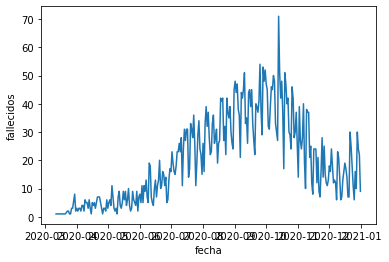

In [25]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.lineplot(x="fecha", y="fallecidos", data=dfTemp2.toPandas())
plt.show()


# Creación de features

Creo nuevas columnas a partir de las existentes para el algoritmo,

## Creo una variable migrante=si/no

In [29]:
from pyspark.sql import functions as F

#1 creo una columna que marque migrante/no migrante
dfcovid=dfcovid.withColumn("migrante", 
    F.when((F.col("pais_nacimiento") == 'Argentina'), 0)\
    .when((F.col("pais_nacimiento") == '*sin dato*'), 0)\
    .when((F.col("pais_nacimiento") == ' '), 0)\
    .otherwise(1)
)


In [30]:
dfcovid.show(5)

+--------------+----+----+---------------------+--------------+-------------+---------------------+-----------------------+--------------------------+---------------+-----------------+-----------------+---------+--------+
|id_evento_caso|sexo|edad|fecha_inicio_sintomas|fecha_apertura|sepi_apertura|origen_financiamiento|residencia_provincia_id|residencia_departamento_id|pais_nacimiento|fecha_internacion|cuidado_intensivo|fallecido|migrante|
+--------------+----+----+---------------------+--------------+-------------+---------------------+-----------------------+--------------------------+---------------+-----------------+-----------------+---------+--------+
|        733072|   F|  37|           2020-02-25|    2020-02-28|         null|              Público|             Descartado|                       410|      Argentina|             null|               NO|       NO|       0|
|        734629|   F|  49|           2020-02-23|    2020-03-02|   2020-03-02|              Privado|             

In [31]:
dfcovid.groupBy('migrante').count().orderBy('count').show()

+--------+------+
|migrante| count|
+--------+------+
|       1| 20179|
|       0|435027|
+--------+------+



# Tipo de financiamiento

lo transformo en una suerte de variable dummy


In [32]:
dfcovid.groupBy('origen_financiamiento').count().orderBy('count').show()

+---------------------+------+
|origen_financiamiento| count|
+---------------------+------+
|              Privado|150574|
|              Público|304632|
+---------------------+------+



In [33]:
dfcovid=dfcovid.withColumn("financiamiento", 
    F.when((F.col("origen_financiamiento") == 'Privado'), 0)\
    .when((F.col("origen_financiamiento") == 'Público'), 1)\
    .otherwise(0)
)


## Transformo sexo a género con valores 1 y 0

In [34]:
dfcovid.groupBy('SEXO').count().orderBy('count').show()

+----+------+
|SEXO| count|
+----+------+
|  NR|  6973|
|   M|218157|
|   F|230076|
+----+------+



In [35]:
dfcovid=dfcovid.withColumn("genero", 
    F.when((F.col("SEXO") == 'NR'), None)\
    .when((F.col("SEXO") == 'M'), 0)\
    .when((F.col("SEXO") == 'F'), 1)\
    .otherwise(0)
)

dfcovid.groupBy('genero').count().orderBy('count').show()

+------+------+
|genero| count|
+------+------+
|  null|  6973|
|     0|218157|
|     1|230076|
+------+------+




## Fecha diagnóstico
Calculo la dierencia entre la fecha de sintomas y la de diagnóstico en días.

In [36]:
from pyspark.sql.functions import datediff, to_date, lit

dfcovid.withColumn("dias_dif", 
              datediff("fecha_diagnostico"),
                       "fecha_sintomas").show()

SyntaxError: unexpected EOF while parsing (<ipython-input-36-e849100fac3a>, line 5)